# Time Series Analysis Final Project

Joshua Grou, Mark Niewierowski, Mez Edoka, Ted Steffens

In [78]:
import numpy as np
from statsmodels.tsa.arima_process import arma_acf
from statsmodels.tsa.arima_process import arma_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox as LBtest
from matplotlib import pyplot as plt
import pandas as pd
import scipy.optimize
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
import pmdarima

## Data Set 1

Monthly Shampoo Sales

### Check For Stationarity

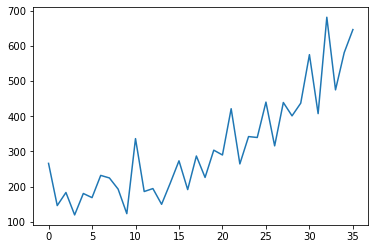

In [3]:
shampoo = pd.read_csv("shampoo.csv")
shampoo = shampoo["Sales"]
plt.plot(shampoo)
plt.show()

From observation the data set does not appear to be stationary, however we should perform the Dickey Fuller Test to confirm.

In [16]:
ad_fuller_res = adfuller(shampoo)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 1.0


The Augmented Dickey Fuller Test returns a p-value of 1, this is a strong indication that the dataset, as suspected, is not stationary and thus we will need to use some techniques to introduce stationarity to the dataset.

### Transform the dataset to stationary

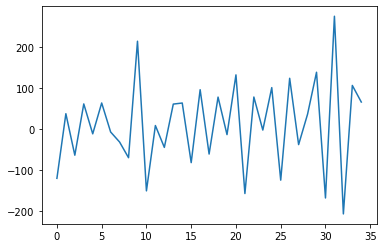

p-value from the Augmented Dickey Fuller Test with software selected lags: 1.799857414168716e-10


In [4]:
first_dif = np.diff(shampoo)

plt.plot(first_dif)
plt.show()

ad_fuller_res = adfuller(first_dif)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

After applying the first difference the Augmented Dickey Fuller test shows that the dataset has been transformed to stationary.

### Investigate the ACF, PACF, and EACF

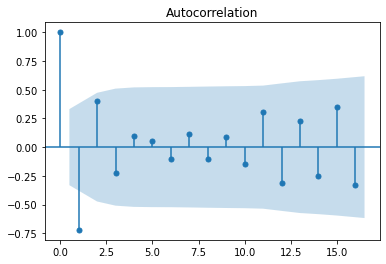

In [23]:
plot_acf(first_dif)
plt.show()

The ACF plot shows that only the first lag is significant in the data, however the second lag could be considered as it is very close to the boundary.

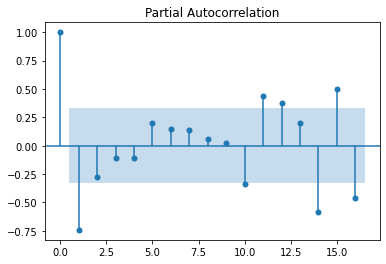

In [8]:
plot_pacf(first_dif, lags=16)
plt.show()

The PACF shows the first lag is significant, however we can observe that it is not really dropping off as would be expected but rather it is dieing out slowly in a sine manner.

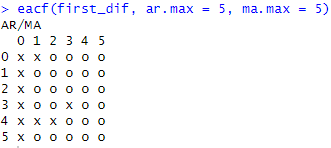

By finding the vertex of a triangle formed by the EACF plot it looks like ARMA(1,1)

By exploring the ACF, PACF, and EACF plots we have suggestions on the differenced dataset we have suggestions for IMA(1,1), IMA(1,2), and ARIMA(1,1,1). In addition to these suggestions we can also use the software package to help identify a model that has best AIC and BIC.

### Fitting the IMA(1,1) model

In [51]:
model_ima = sm.tsa.SARIMAX(shampoo, order=(0,1,1))
res_ima = model_ima.fit()

print(res_ima.summary())

resid_ima = res_ima.resid
preds = res_ima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -204.563
Date:                Sat, 25 Mar 2023   AIC                            413.125
Time:                        10:25:15   BIC                            416.236
Sample:                             0   HQIC                           414.199
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5924      0.176     -3.367      0.001      -0.937      -0.248
sigma2      6904.9684   1640.390      4.209      0.000    3689.862    1.01e+04
Ljung-Box (L1) (Q):                   6.70   Jarque-

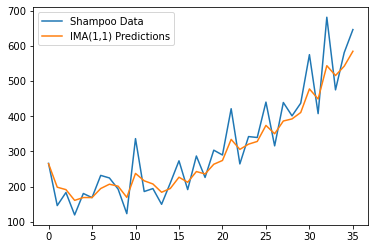

In [53]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "IMA(1,1) Predictions"])
plt.show()

Viewing the model values against the actual the fit appears to be reasonable, however there are some peaks in the model that are not captured here. Next we will investigagte the residuals.

### Residual Analysis for IMA(1,1) Model

#### Test For Normality

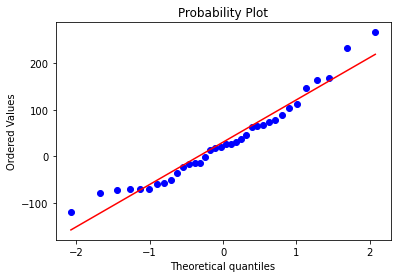

In [54]:
stats.probplot(resid_ima, dist="norm", plot=plt)
plt.show()

The probability plot gives the appearance that the residuals are not normally distributed, next would be the Shapiro Wilks Test to confirm or deny the nrmality assumption.

In [58]:
shap = shapiro(resid_ima)

print("p-value from the shapiro-wilks test: " + str(shap[1]))

p-value from the shapiro-wilks test: 0.13012586534023285


The shapiro wilks test does not show that there is significant evidence to reject the null hypothesis that the data is coming from normal, thus we can say that the residuals are approximately normally distributed.

#### Test for random generation.

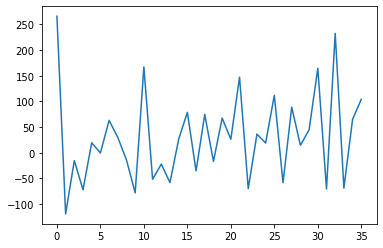

In [61]:
plt.plot(resid_ima)
plt.show()

In [59]:
runs_res = runstest_1samp(resid_ima)

print("Runs test p value: " + str(runs_res[1]))

Runs test p value: 0.0367138563627041


The runs test shows enough evidence to reject the null hypothesis that the residuals were generated randomly. This may be an indication that there are uncaptured dependancies in the data.

#### Test for correlation among residuals

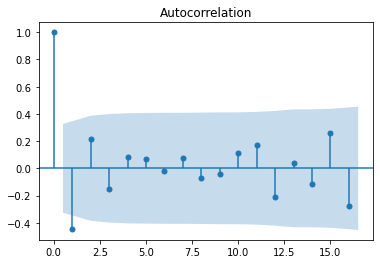

In [62]:
plot_acf(resid_ima)
plt.show()

In [64]:
lb_res = LBtest(resid_ima)

print("The p-values for the Ljung-Box test for the lags are: " + str(lb_res[1]))

The p-values for the Ljung-Box test for the lags are: [0.00535679 0.00807484 0.01409806 0.02783268 0.04978173 0.0852106
 0.12283592 0.16809049 0.22922827 0.26154694 0.23536913 0.16764034
 0.21673505 0.23199219 0.11255044 0.04061431]


c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


By viewing the plot of the ACF we can see that the residuals may have some correlation because the first lag meets the significance threshold. By running the Ljung-Box Test we also see that it returns significant evidance of uncaptured dependance which indicates that the IMA(1,1) model may not be the best fit for the data set.

### Fitting the IMA(1,2) Model

In [65]:
model_ima = sm.tsa.SARIMAX(shampoo, order=(0,1,2))
res_ima = model_ima.fit()

print(res_ima.summary())

resid_ima = res_ima.resid
preds = res_ima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -196.730
Date:                Sat, 25 Mar 2023   AIC                            399.461
Time:                        10:53:41   BIC                            404.127
Sample:                             0   HQIC                           401.072
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3002      2.420     -0.537      0.591      -6.042       3.442
ma.L2          0.9940      3.683      0.270      0.787      -6.225       8.213
sigma2      3748.6601   1.37e+04      0.274      0.7

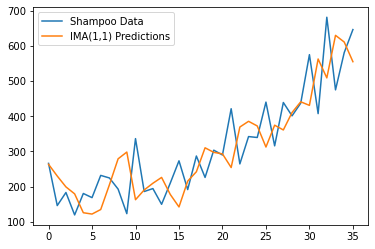

In [66]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "IMA(1,1) Predictions"])
plt.show()

Here again the model seems to be a reasonable fit for the data, and appears to be more capturing of the peaks and dips than the IMA(1,1) model

### Residual analysis for IMA(1,2) model

#### Test for normality

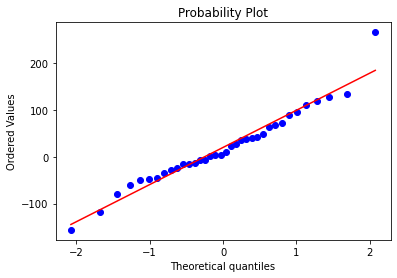

In [67]:
stats.probplot(resid_ima, dist="norm", plot=plt)
plt.show()

The QQ plot shows some evidence supporting the normal distribution, more so than the IMA(1,1) model.

In [68]:
shap = shapiro(resid_ima)

print("p-value from the shapiro-wilks test: " + str(shap[1]))

p-value from the shapiro-wilks test: 0.34869128465652466


The shaprio wilks test confirms this as we cannot reject the null hypothesis that the residuals are coming from normal distribution.

#### Test for random generation

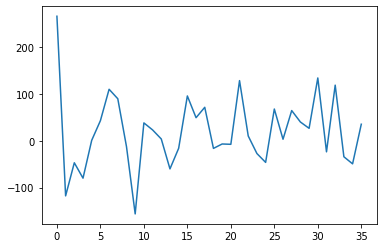

In [69]:
plt.plot(resid_ima)
plt.show()

In [70]:
runs_res = runstest_1samp(resid_ima)

print("Runs test p value: " + str(runs_res[1]))

Runs test p value: 0.6240859056985628


The Runs test does not show sufficient evidence to reject the null hypothesis, thus we must accept that the residuals are generated randomly.

#### Test for uncaptured Dependancy.

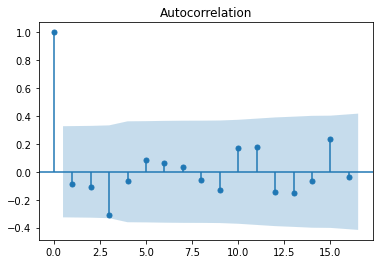

In [71]:
plot_acf(resid_ima)
plt.show()

In [72]:
lb_res = LBtest(resid_ima)

print("The p-values for the Ljung-Box test for the lags are: " + str(lb_res[1]))

The p-values for the Ljung-Box test for the lags are: [0.59873921 0.69245122 0.19979332 0.30637728 0.40035232 0.50467753
 0.61470622 0.69703447 0.69484682 0.62730758 0.55896788 0.54370694
 0.51414012 0.57030491 0.37719859 0.4406463 ]


c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [55]:
def evaluate_residuals(residuals):
    #check the QQ plot
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()
    #run shapiro-wilks test
    shap = shapiro(residuals)
    print("p-value from the shapiro-wilks test: " + str(shap[1]))
    if shap[1] < 0.05:
        print("The p value of the shapiro wilks test indicates significant evidence against normal")
    else:
        print("The p value of the shapiro wilks test does not indicate significant evidence against normal")
    #runs test
    runs_res = runstest_1samp(residuals)

    print("Runs test p value: " + str(runs_res[1]))
    if runs_res[1] < 0.05:
        print("The p value of the runs test indicates significant evidence against random")
    else:
        print("The p value of the runs test does not indicate significant evidence against random")

    plot_acf(residuals)
    plt.show()

    lb_res = LBtest(residuals)

    print("Results from Ljung-Box Test: \n")
    print(lb_res)

    return

### Fitting the ARIMA(1,1,1) Model

In [19]:
model_arima = sm.tsa.SARIMAX(shampoo, order=(1,1,1))
res_arima = model_arima.fit()

print(res_arima.summary())

resid_arima = res_arima.resid
preds = res_arima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -200.391
Date:                Tue, 28 Mar 2023   AIC                            406.782
Time:                        20:58:04   BIC                            411.448
Sample:                             0   HQIC                           408.393
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0426   1386.817      3.881      0.0

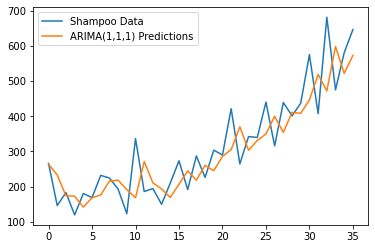

In [20]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "ARIMA(1,1,1) Predictions"])
plt.show()

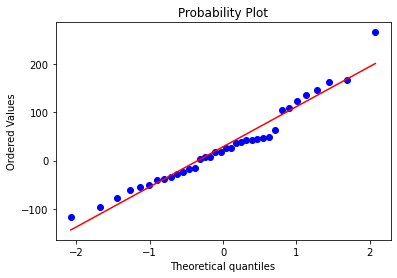

p-value from the shapiro-wilks test: 0.20880398154258728
The p value of the shapiro wilks test does not indicate significant evidence against normal
Runs test p value: 0.5552223043858198
The p value of the runs test does not indicate significant evidence against random


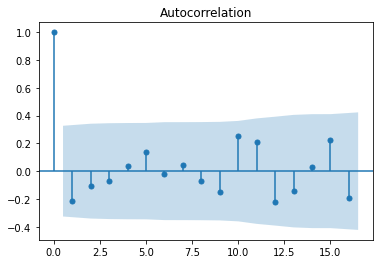

The p-values for the Ljung-Box test for the lags are: [0.18037556 0.32014995 0.48113122 0.63866781 0.64682863 0.7615063
 0.83891526 0.8834854  0.84597967 0.61345063 0.47895866 0.34232617
 0.33686104 0.40662341 0.2702842  0.20022304]


c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [21]:
evaluate_residuals(resid_arima)

### Overfitting Model IMA(1,3)

In [22]:
model_ima = sm.tsa.SARIMAX(shampoo, order=(0,1,3))
res_ima = model_ima.fit()

print(res_ima.summary())

resid_ima = res_ima.resid
preds = res_ima.predict(1,36)

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -196.634
Date:                Tue, 28 Mar 2023   AIC                            401.269
Time:                        21:06:15   BIC                            407.490
Sample:                             0   HQIC                           403.416
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2346      7.830     -0.158      0.875     -16.582      14.113
ma.L2          0.8891     11.186      0.079      0.937     -21.035      22.813
ma.L3          0.0823      1.240      0.066      0.9

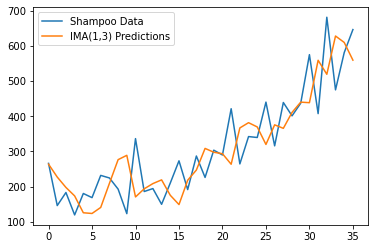

In [24]:
preds = preds.reset_index(drop = True)

plt.plot(shampoo)
plt.plot(preds)
plt.legend(["Shampoo Data", "IMA(1,3) Predictions"])
plt.show()

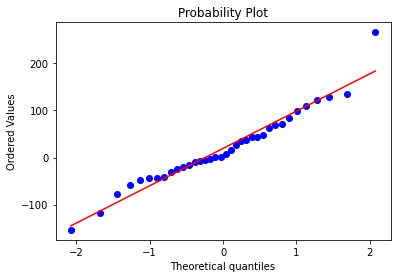

p-value from the shapiro-wilks test: 0.29072877764701843
The p value of the shapiro wilks test does not indicate significant evidence against normal
Runs test p value: 0.6615987635795131
The p value of the runs test does not indicate significant evidence against random


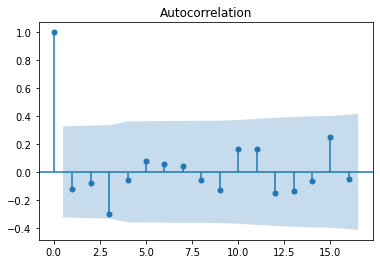

The p-values for the Ljung-Box test for the lags are: [0.43634568 0.64869948 0.20326472 0.31490264 0.417581   0.52624403
 0.63190034 0.71387454 0.71167223 0.65501635 0.59815095 0.56515599
 0.55412053 0.6083194  0.3851872  0.44210502]


c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [25]:
evaluate_residuals(resid_ima)

### Data Set 1 Conclusions

After fitting all of the models proposed by the ACF, PACF, and EACF plots we find that the IMA(1,2) model seems to be performing the best. This model has the lowest AIC and BIC, while having random, normally distributed, and un-correlated residuals. The ARIMA(1,1,1) model was comparable, having again random, normally distributed, and uncorrelated residuals, but the AIC and BIC are lower than the IMA(1,2) models.

To check for confirm the IMA(1,2) further an overfitting model was also created as IMA(1,3). From observing the parameters of this model we can see that the MA(3) parameter is close to zero and its inclusion does not much change the MA(1) and MA(2) parameters from the IMA(1,2) fit. This is an indication that going to IMA(1,3) would be overfitting and that IMA(1,2) is a good selection.

## Data Set 2

monthly sunspots

     Month  Sunspots
0  1749-01      58.0
1  1749-02      62.6
2  1749-03      70.0
3  1749-04      55.7
4  1749-05      85.0


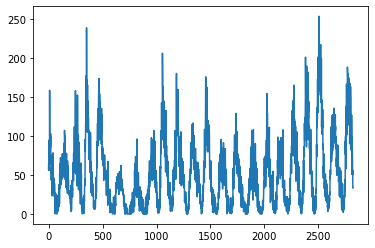

In [31]:
spots = pd.read_csv("monthly-sunspots.csv")
print(spots.head())
spots = spots["Sunspots"]
plt.plot(spots)
plt.show()

In [32]:
ad_fuller_res = adfuller(spots)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 2.333452143866137e-16


The data set is showing as stationary from the Dickey Fuller test, however there is a very strong seasonality oberseved here that will need to be inspected.

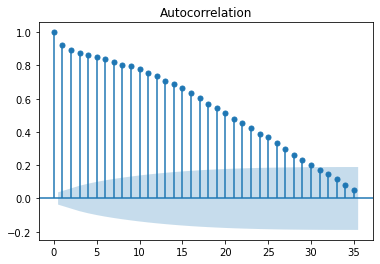

In [33]:
plot_acf(spots)
plt.show()

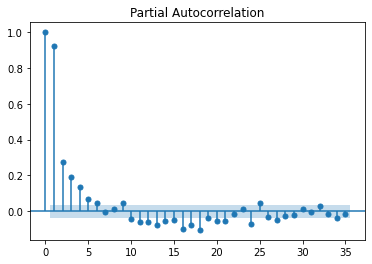

In [35]:
plot_pacf(spots)
plt.show()

Here we don't really get anything of value as the sample size is too large, we can try to aggregate by year rather than monthly.

In [5]:
spots = pd.read_csv("monthly-sunspots.csv")
spots["Month"] = spots["Month"].astype("datetime64")
yearly = spots.groupby(spots['Month'].dt.year)['Sunspots'].agg(['mean'])

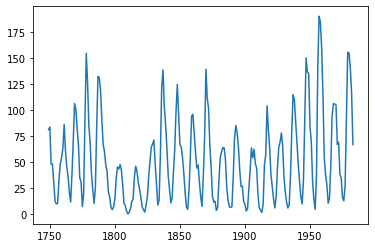

In [6]:
plt.plot(yearly)
plt.show()

In [7]:
yearly_spots = yearly["mean"]

ad_fuller_res = adfuller(yearly_spots)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 0.1475320518631621


The yearly aggregated data shows as not stationary according to the dickey fuller test, so we will need to apply some transformations to make it stationary.

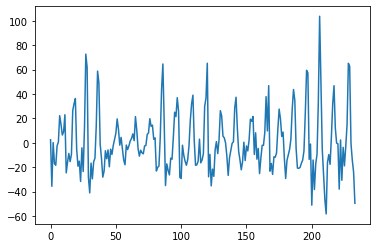

In [74]:
diff = np.diff(yearly_spots, 1)
plt.plot(diff)
plt.show()

In [75]:
ad_fuller_res = adfuller(diff)

print("p-value from the Augmented Dickey Fuller Test with software selected lags: " + str(ad_fuller_res[1]))

p-value from the Augmented Dickey Fuller Test with software selected lags: 2.463807611044525e-22


After taking the first difference the data is shown as stationary by the augmented dickey fuller test.

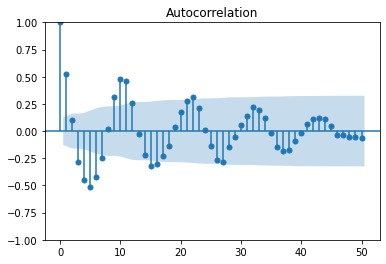

In [76]:
plot_acf(diff, lags = 50)
plt.show()

c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


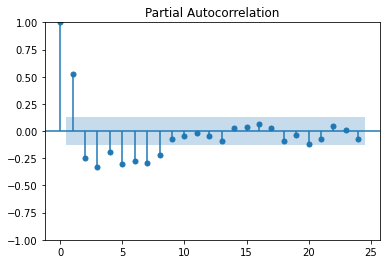

In [77]:
plot_pacf(diff)
plt.show()



From the ACF and PACF Plot there are a lot of options that look reasonable, to find the best option we can use an iterative approach to solve for the models with the lowest BIC which is good for penalizing models that have excessive parameters.

We can use this approach with PMDARIMA auto_arima function which can help us to find the model with the lowest BIC score. To use this we do need to identify the differencing level required which is 1 according to the stationarity tests on the data, the next thing is to identify the seasonal period. From our ACF we can tell that the seasonal period should be 5 years. This information is required to be provided apriori to auto_arima.

Because we have many observations available we can segment the dataset into a training, validation, and testing dataset. The last 60 points will be split into 30 points for validation and 30 points for testing. This will allow us to see how well our model is forecasting out from the known data. By providing a validation set we are also able to have the auto-arima search looking for models that forecast well by measuring the MSE of each model on the next 30 data points.

In [85]:
yearly_spots = yearly_spots.reset_index(drop=True)
yearly_spots_train = yearly_spots.iloc[:-30]
yearly_spots_test = yearly_spots.iloc[-30:]
model = pmdarima.arima.auto_arima(y = yearly_spots_train, start_p = 1, d =1, start_q = 1, m=5, max_P = 4, max_Q = 5, D=1, out_of_sample_size=30, information_criterion='bic', maxiter= 1000)
print(model)
model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,0), seasonal_order=(3,1,1,5), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())

resid_pmd = res_pmd.resid
preds = res_pmd.predict(1,235)

 ARIMA(3,1,0)(3,1,1)[5]          
                                      SARIMAX Results                                      
Dep. Variable:                                mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 0)x(3, 1, [1], 5)   Log Likelihood                -850.855
Date:                             Sun, 09 Apr 2023   AIC                           1717.710
Time:                                     15:57:02   BIC                           1744.056
Sample:                                          0   HQIC                          1728.373
                                             - 205                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3004      0.056      5.330      0.000       0.190      

c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


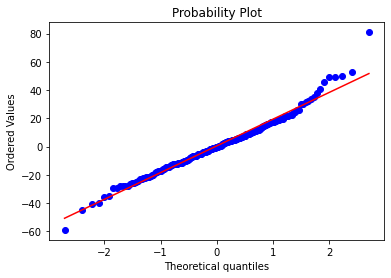

p-value from the shapiro-wilks test: 0.003950295504182577
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.11901487944538326
The p value of the runs test does not indicate significant evidence against random


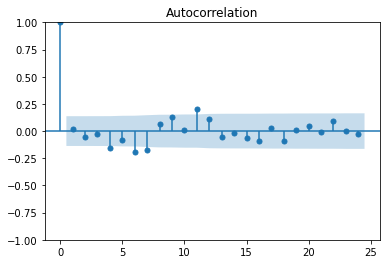

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.069545   0.792000
2    0.591567   0.743948
3    0.696484   0.874031
4    5.915038   0.205584
5    7.204557   0.205866
6   14.946135   0.020680
7   21.711250   0.002848
8   22.611766   0.003900
9   26.300059   0.001824
10  26.328769   0.003322


In [86]:
evaluate_residuals(resid_pmd)

The initial model found by pmd_arima has some uncaptured dependence in the data at lag 6 and on as indicated by statistically significant results in the Ljung-Box Test. This indicates that the model may not be a good fit for the data that is here. To correct this we can try to add the MA(1) parameter as suggested by the auto-correlation plot.

In [87]:
model_pmd = sm.tsa.SARIMAX(yearly_spots_train, order=(3,1,1), seasonal_order=(3,1,1,5), simple_differencing=False)
res_pmd = model_pmd.fit()

print(res_pmd.summary())

resid_pmd = res_pmd.resid
preds = res_pmd.predict(1,235)

                                     SARIMAX Results                                     
Dep. Variable:                              mean   No. Observations:                  205
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 5)   Log Likelihood                -838.081
Date:                           Sun, 09 Apr 2023   AIC                           1694.163
Time:                                   16:00:36   BIC                           1723.802
Sample:                                        0   HQIC                          1706.158
                                           - 205                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1366      0.083     13.671      0.000       0.974       1.299
ar.L2         -0.3243      0.104     -3.105

c:\Users\joshg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


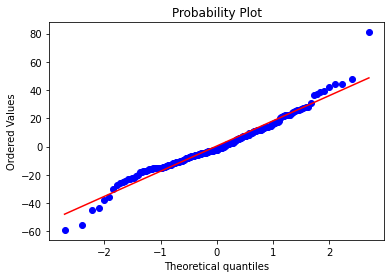

p-value from the shapiro-wilks test: 8.339775376953185e-05
The p value of the shapiro wilks test indicates significant evidence against normal
Runs test p value: 0.1561688108110983
The p value of the runs test does not indicate significant evidence against random


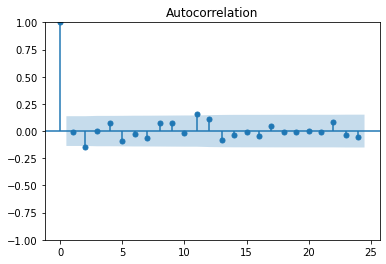

Results from Ljung-Box Test: 

      lb_stat  lb_pvalue
1    0.010047   0.920160
2    4.377509   0.112056
3    4.381535   0.223104
4    5.500281   0.239705
5    7.258478   0.202116
6    7.461995   0.280225
7    8.459163   0.293850
8    9.616843   0.292955
9   10.747346   0.293425
10  10.792844   0.373884


In [88]:
evaluate_residuals(resid_pmd)

From the analysis we can see that there is no longer uncaptured dependance in the data as indicated by significant values in the Ljung Box test. We can then say that we have captured all of the dependance available in the dataset. We also can see that the AIC is a bit lower than that of the suggested model from pmd_arima, however there is a small penalty to the BIC.

Next we can try to forecast the remaining 30 data points to see how well the model is able to do that.

mean        mean    mean_se  mean_ci_lower  mean_ci_upper
205    17.000756  15.604118     -13.582753      47.584264
206    35.862203  24.966483     -13.071205      84.795611
207    67.930443  31.283241       6.616418     129.244469
208    96.143694  33.714327      30.064827     162.222560
209   103.175159  34.022419      36.492443     169.857874


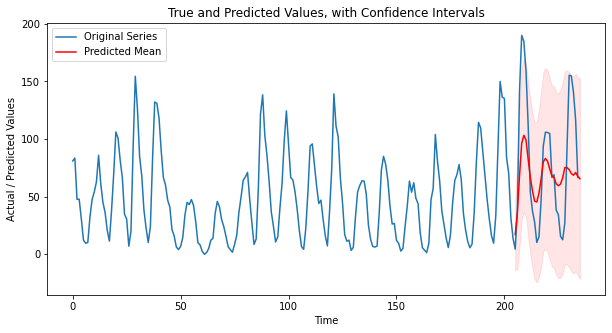

In [98]:
preds_df = (res_pmd
            .get_prediction(start=205, end=235)
            .summary_frame(alpha=0.05)
)
print(preds_df.head())

# Plot the training data, predicted means and confidence intervals
fig, ax = plt.subplots(figsize=(10,5))
ax = yearly_spots.plot(label='Original Series')
ax.set(
    title='True and Predicted Values, with Confidence Intervals',
    xlabel='Time',
    ylabel='Actual / Predicted Values'
)
preds_df['mean'].plot(ax=ax, style='r', label='Predicted Mean')
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='r', alpha=0.1
)
legend = ax.legend(loc='upper left')

Here we can see that the forecasting for the first few years out is doing quite well at predicting the trend, however as the time scale moves farther away the prediction begins to collapse to the mean losing some forecasting power. It is important to keep in mind that by the end of the forecasting period this is looking 30 years into the future which is quite some time out.